In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import naludaq
print(f"Naludaq version: {naludaq.__version__}")

Naludaq version: 0.31.7


In [129]:
from naludaq.backend import DiskAcquisition

ACQ_PATH = "data/SineWave_100MHz/"
channels = 4
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH) as acq:
    print("Board model:", acq.params["model"])
    print("Number of events:", len(acq))
    print("Pedestals stored:", acq.pedestals is not None)

acq= DiskAcquisition(ACQ_PATH)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals=acq.pedestals
params = acq.params
corrector = PedestalsCorrecter(params, pedestals)

Board model: dsa-c10-8
Number of events: 1013
Pedestals stored: True


This is all assuming the starting cell is correct, which is everything but sure

In [130]:
num_cells = 128
cell_data = {i: [] for i in range(num_cells)}  # Initialize storage for each cell

for ev_num in range(len(acq)):
    event=acq[ev_num]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"]
    time=(time[4] - time[4][0]) * 0.1 
    start_window = event['start_window'] % num_cells 
    adc_values=corrected_event["data"]   
    
    for i in range(1024):
        cell = (start_window + i) % num_cells  # Compute actual cell index
        cell_data[cell].append(adc_values[4][i])  
        

cell_offset = []
for i in range(128):
    cell_offset.append(np.median(cell_data[i]))

for cell in range(num_cells):
    cell_data[cell] = np.array(cell_data[cell]) - cell_offset[cell] 

[ 0.  12.8 25.6 38.4 51.2 64.  76.8 89.6]


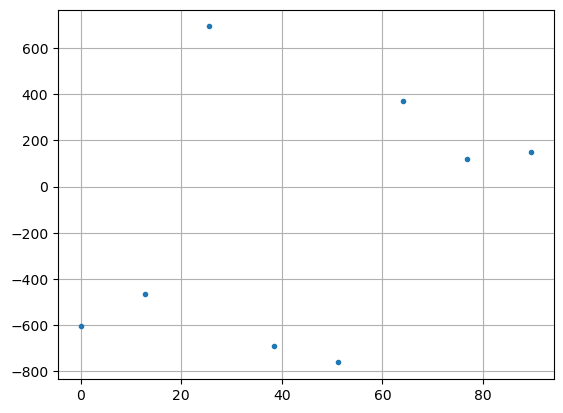

In [131]:
time_0 = np.arange(0, 8 * 12.8, 12.8)
print(time_0)
# cell 1, event 0
plt.plot(time_0, cell_data[0][0:8],'.')      # cell_data[cell][0-7 is first event and so on]
# plt.plot(time_0, cell_data[0][8:16],'.')      # cell_data[cell][8-16 is second event and so on]
plt.grid()

2648.8
Offset: 0.0


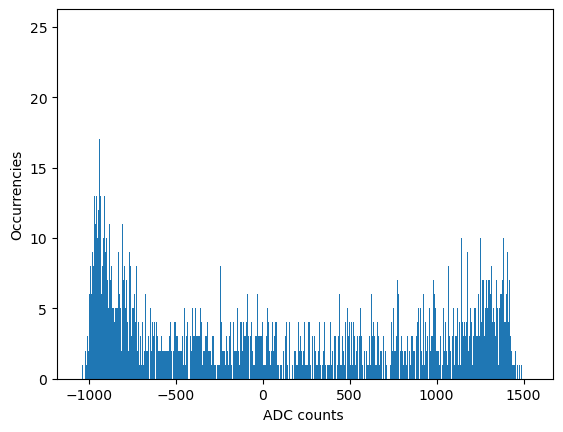

In [132]:
cell_number = 77

print(np.max(cell_data[1]) - np.min(cell_data[1]))
# Convert cell_data[1] to a NumPy array (if not already)
cell_1_data = np.array(cell_data[cell_number])  # Shape: (8104,)
# cell_1_data = cell_1_data - np.median(cell_1_data)  # Subtract the median
plt.hist(cell_1_data,bins=2649);
plt.xlabel("ADC counts ")
plt.ylabel("Occurrencies")
print('Offset:', np.median(cell_data[cell_number]))

* Look for an event that has got a point on the offset

In [133]:
# Convert cell_data[1] to a NumPy array (if not already)
cell_1_data = np.array(cell_data[cell_number])  # Shape: (8104,)
cell_1_data = cell_1_data - np.median(cell_1_data)  # Subtract the median
# Find the indices where ADC count is 348
indices_offset = np.where((cell_1_data >= 0) & (cell_1_data < 1))[0]

# Each event consists of 8 points, so compute the event index for each
event_indices = indices_offset // 8  # Integer division to find the event number

# Print results
print(f"Total occurrences of ADC 348: {len(indices_offset)}")
print(f"Indices in cell_data[1]: {indices_offset}")
print(f"Corresponding event indices: {event_indices}")
    

Total occurrences of ADC 348: 4
Indices in cell_data[1]: [ 908 1290 6307 6350]
Corresponding event indices: [113 161 788 793]


### This is an example of an event like the ones we would like

In [134]:
def re_phase(event, offset):
    time_1 = np.array([0., 12.8, 25.6, 38.4, 51.2, 64., 76.8, 89.6])
    start_idx = np.where(time_1 == offset)[0][0]
    shifted_event = np.roll(event, -start_idx)
    return shifted_event

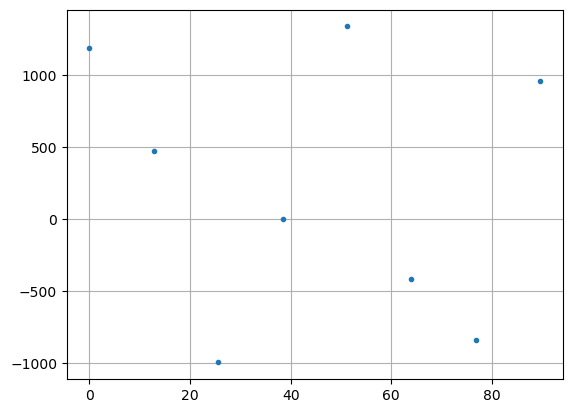

In [135]:
time_0 = np.arange(0, 8 * 12.8, 12.8)
# print(cell_data[cell_number][1281])
plt.plot(time_0, cell_data[cell_number][event_indices[2]*8:event_indices[2]*8+8],'.')      # cell_data[event][0-7 is first cell and so on]
# plt.plot(time_0, cell_data[0][8:16],'.')      # cell_data[event][0-7 is first cell and so on]
plt.grid()

* Let's shift the datapoints in ordeer to have the 0 point as the starting point and being able to obtain the phase

In [136]:
# Original time array
time_1 = np.array([0., 12.8, 25.6, 38.4, 51.2, 64., 76.8, 89.6])

# Your event data (example placeholder here — use your actual data)
event_2 = cell_data[cell_number][event_indices[2]*8:event_indices[2]*8+8]

# Step 1: find the index of 38.4
start_idx = np.where(time_1 == 38.4)[0][0]  # should be 3

# Step 2: roll the data so the point at 38.4 comes first
shifted_event_2 = np.roll(event_2, -start_idx)

Fitted parameters: A=1110.579, f=0.098, phi=0.213, C=211.050


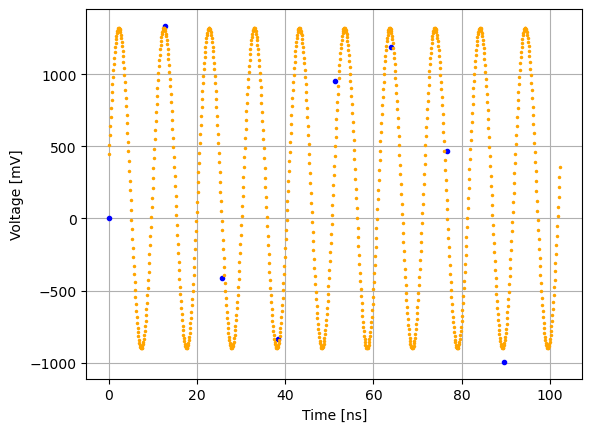

In [137]:
def sinewave(x, A, f, phi, c):
    return A * np.sin(2 * np.pi * f * x + phi) + c

p, _ = curve_fit(sinewave, time_0, shifted_event_2, p0=[2500, 0.100, 0, 0])

A_fit, f_fit, phi_fit, C_fit = p
print(f"Fitted parameters: A={A_fit:.3f}, f={f_fit:.3f}, phi={phi_fit:.3f}, C={C_fit:.3f}")

plt.plot(time_0, shifted_event_2,'.', color='blue', label="Data")
plt.plot(time, sinewave(time, *p),'.',markersize=3,color = 'orange', label="Fit")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()

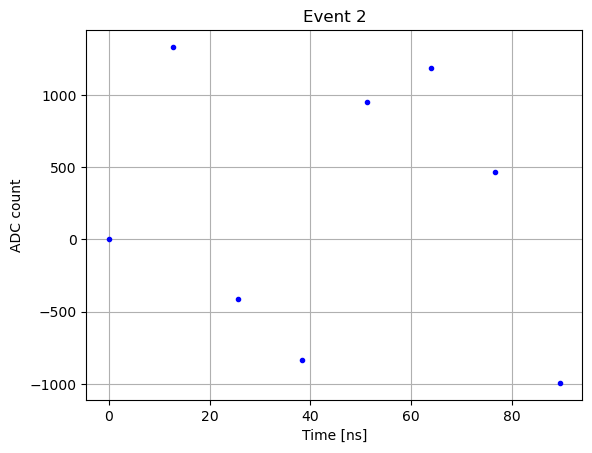

In [138]:
plt.plot(time_0, shifted_event_2,'.', color='blue', label="Data")

plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 2")
plt.grid()

* Different sample [0], still with a point in 0

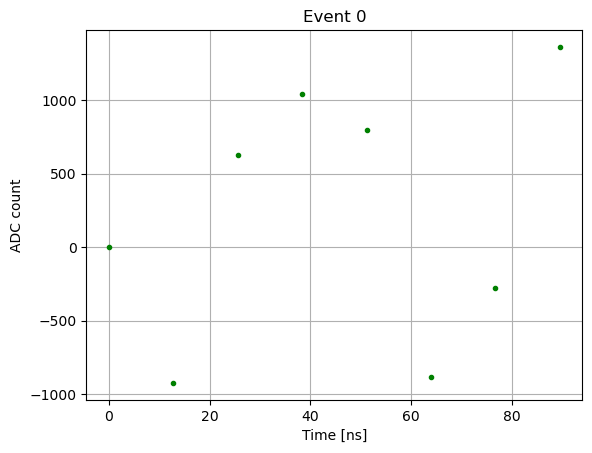

In [139]:
event_0 = cell_data[cell_number][event_indices[0]*8:event_indices[0]*8+8]
shifted_event_0 = np.roll(event_0, -4)

plt.plot(time_0, shifted_event_0,'.', color='green', label="Data")
plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 0")
plt.grid()

* Different sample [1]

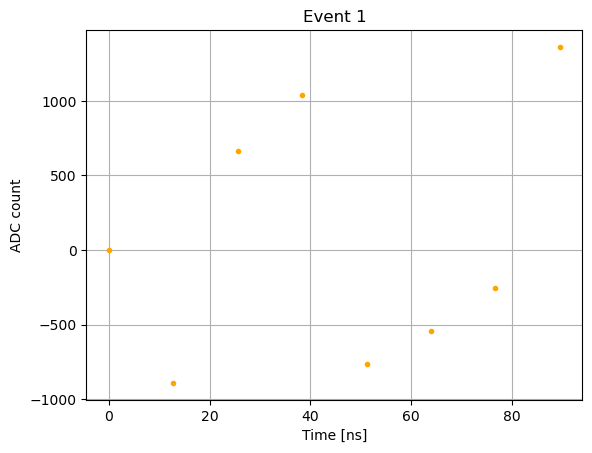

In [140]:
event_1 = cell_data[cell_number][event_indices[1]*8:event_indices[1]*8+8]
shifted_event_1 = np.roll(event_1, -2)

plt.plot(time_0, shifted_event_1,'.', color='orange', label="Data")
plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 1")
plt.grid()

* Different sample [3]

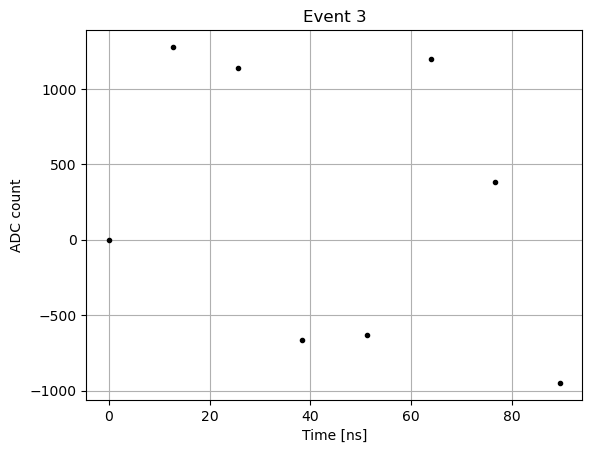

In [141]:
event_3 = cell_data[cell_number][event_indices[3]*8:event_indices[3]*8+8]
shifted_event_3 = np.roll(event_3, -6)

plt.plot(time_0, shifted_event_3,'.', color='black', label="Data")
plt.xlabel("Time [ns]")
plt.ylabel("ADC count");
plt.title("Event 3")
plt.grid()

* Ideal input

-98.2287250728689


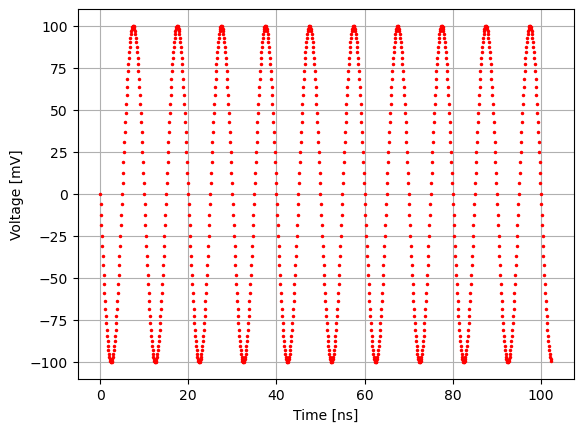

In [142]:
def sinewave(x, A, f, phi, c):
    return A * np.sin(2 * np.pi * f * x + phi) + c

# x = np.linspace(0,51.1,512)
x = np.linspace(0,102.3,1024)
phi = 0
# phi = np.pi
# phi = phi_fit
# sine = sinewave(x, 100,  0.100, 0, 0)  # Generate sine wave
sine = sinewave(x, 100,  0.100, np.pi, 0)  

plt.plot(x, sine,'.', markersize=3, color='red', label="Input Sine Wave")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()
print(sine[128])

* Input values

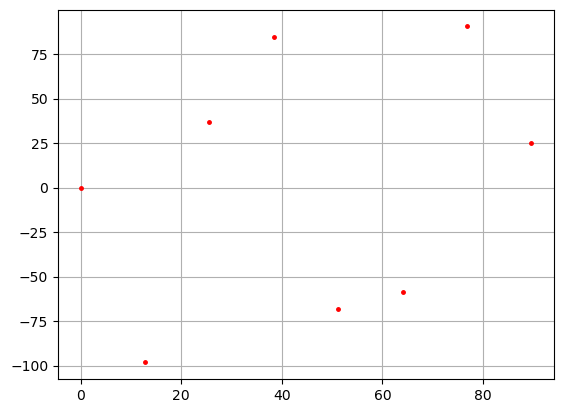

In [143]:
Input = []
Output_0 = []
Output_2 = []
for i in range(8):
    Input.append(sine[i*128])
plt.plot(time_0, Input,'.', markersize=5, color='red', label="Input Sine Wave");
plt.grid()

In [144]:
np.set_printoptions(suppress=True)
print(Input)
print(shifted_event_2)
print(shifted_event_3)

[1.2246467991473532e-14, -98.2287250728689, 36.812455268467524, 84.43279255020164, -68.4547105928682, -58.77852522924832, 90.4827052466019, 24.86898871648591]
[   0.9 1333.9 -415.  -837.6  952.8 1187.6  469.4 -993.7]
[   0.1 1278.6 1141.  -662.  -630.9 1200.8  382.5 -949.3]


Text(0, 0.5, 'Output [ADC]')

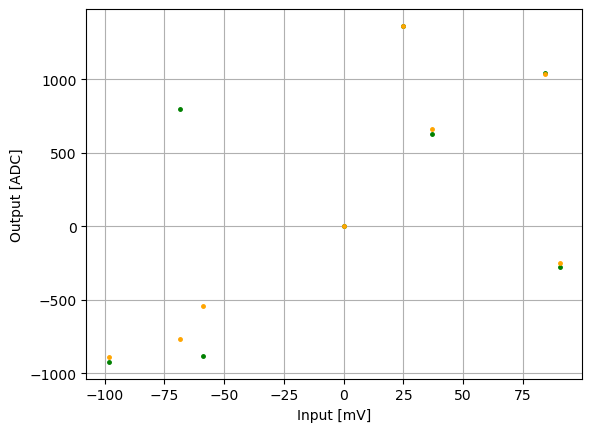

In [155]:
plt.plot(Input, shifted_event_0, '.', markersize=5, color='green', label="Input Sine Wave")
plt.plot(Input, shifted_event_1, '.', markersize=5, color='orange', label="Input Sine Wave")
# plt.plot(Input, shifted_event_3, '.', markersize=5, color='black', label="Input Sine Wave")
# plt.plot(Input, shifted_event_2, '.', markersize=5, color='blue', label="Input Sine Wave")
plt.grid()
plt.xlabel("Input [mV]")
plt.ylabel("Output [ADC]")


Now random stuff

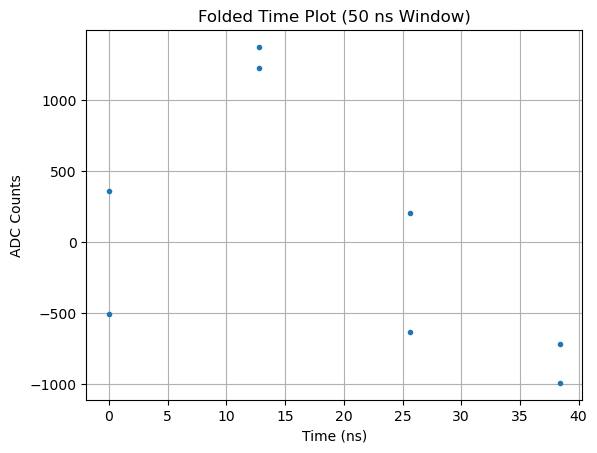

In [146]:
time_0_folded = (np.arange(0, 8 * 12.8, 12.8)) % 51.2  # Fold time into a 50 ns window

plt.plot(time_0_folded, cell_data[1][event_indices[0] * 8 : event_indices[0] * 8 + 8], '.')
plt.grid()
plt.xlabel("Time (ns)")
plt.ylabel("ADC Counts")
plt.title("Folded Time Plot (50 ns Window)")
plt.show()

Fitted parameters: A=1165.493, f=0.101, phi=-0.182, C=137.135
1300.3499993568716
1372.55


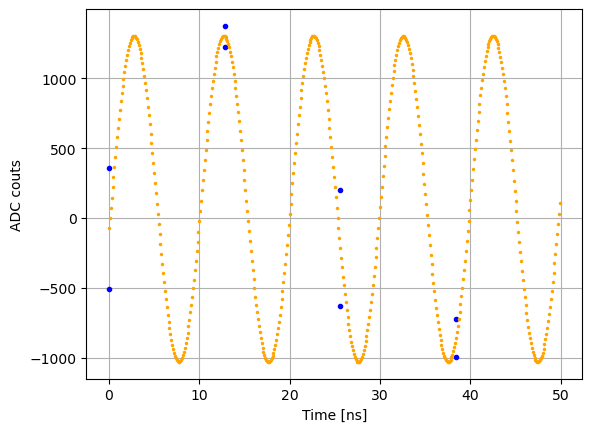

In [147]:
p1, _1 = curve_fit(sinewave, time_0_folded, cell_data[1][event_indices[0]*8:event_indices[0]*8+8], p0=[2500, 0.1, 0, 0])

A_fit1, f_fit1, phi_fit1, C_fit1 = p1
print(f"Fitted parameters: A={A_fit1:.3f}, f={f_fit1:.3f}, phi={phi_fit1:.3f}, C={C_fit1:.3f}")

plt.plot(time_0_folded, cell_data[1][event_indices[0]*8:event_indices[0]*8+8],'.', color='blue', label="Data")
plt.plot(time[:500], sinewave(time[:500], *p1),'.',markersize=3,color = 'orange', label="Fit")
plt.xlabel("Time [ns]")
plt.ylabel("ADC couts");
plt.grid()

print(sinewave(time_0_folded,*p1)[1])
print(cell_data[1][1280])

Same cell, different event

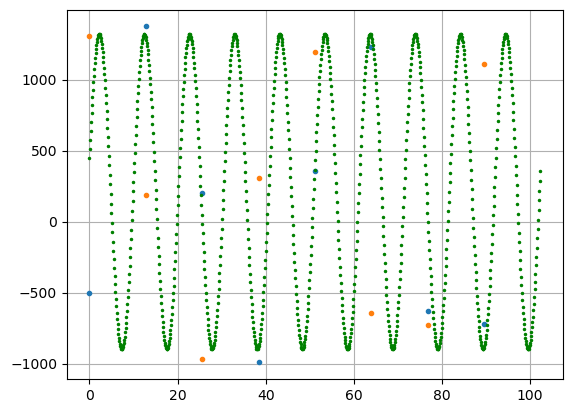

In [148]:
for ev in range(2):
    plt.plot(time_0, cell_data[1][event_indices[ev]*8:event_indices[ev]*8+8],'.')
plt.plot(time, sinewave(time, *p),'.',markersize=3,color = 'green', label="Fit")
plt.grid()

Fitted parameters: A=1126.642, f=0.098, phi=1.874, C=177.076
1300.3499993568716
1372.55


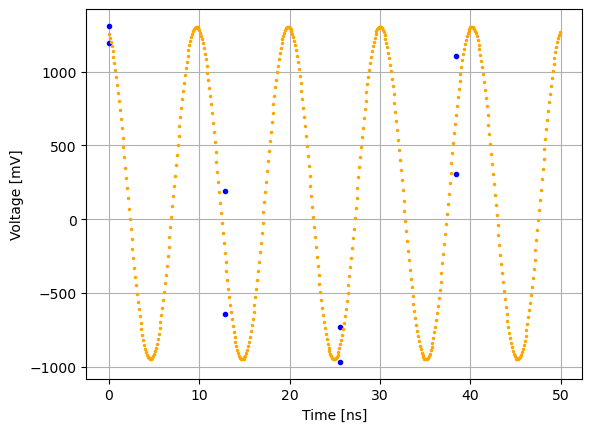

In [149]:
p2, _ = curve_fit(sinewave, time_0_folded, cell_data[1][event_indices[1]*8:event_indices[1]*8+8], p0=[2500, 0.1, 0, 0])

A_fit1, f_fit1, phi_fit1, C_fit1 = p2
print(f"Fitted parameters: A={A_fit1:.3f}, f={f_fit1:.3f}, phi={phi_fit1:.3f}, C={C_fit1:.3f}")

plt.plot(time_0_folded, cell_data[1][event_indices[1]*8:event_indices[1]*8+8],'.', color='blue', label="Data")
plt.plot(time[:500], sinewave(time[:500], *p2),'.',markersize=3,color = 'orange', label="Fit")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()

print(sinewave(time_0_folded,*p1)[1])
print(cell_data[1][1280])

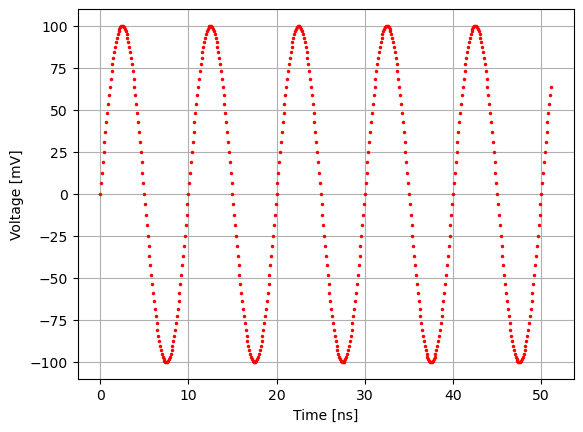

In [150]:
x1 = np.linspace(0,51.1,512)
sine1 = sinewave(x1, 100,  0.100, 0, 0)  # Generate sine wave

plt.plot(x1, sine1,'.', markersize=3, color='red', label="Input Sine Wave")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()

Checked the shifting and it works. I don't think this is the way to proceed.

In [151]:
print(time_0)
print(time_0_folded)

[ 0.  12.8 25.6 38.4 51.2 64.  76.8 89.6]
[ 0.  12.8 25.6 38.4  0.  12.8 25.6 38.4]


[ 0.  12.8 25.6 38.4  0.  12.8 25.6 38.4]


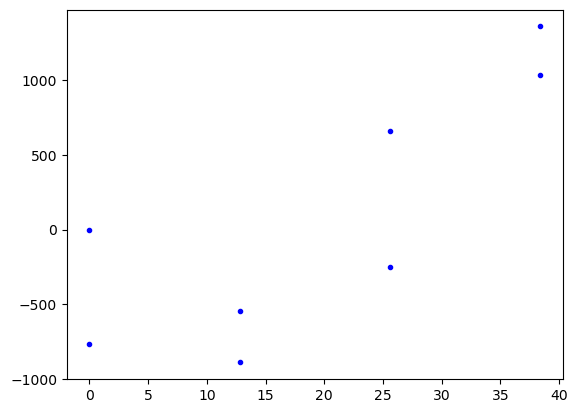

In [152]:
plt.plot(time_0_folded, shifted_event_1,'.', color='blue', label="Data");
print(time_0_folded)